<a href="https://colab.research.google.com/github/xinformatics/WindowSHAP/blob/main/mimic3_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/amia2023/WindowSHAP-main/* '/content/'

In [39]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

In [5]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [6]:
def build_model(input_shape,head_size, num_heads,ff_dim,num_transformer_blocks,mlp_units,dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [7]:
import numpy as np

In [8]:
data = np.load('train_test_x_y.npz')
train_x, test_x, train_y, test_y  = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] 

In [9]:
train_y = train_y.reshape(-1,1)
test_y  = test_y.reshape(-1,1)

In [10]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((18390, 48, 26), (4598, 48, 26), (18390, 1), (4598, 1))

In [37]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_y.squeeze()),
                                        y = train_y.squeeze())
#class_weights = dict(zip(np.unique(train_classes), class_weights)),
class_weights

array([0.55532069, 5.0191048 ])

In [11]:
input_shape = train_x.shape[1:]

In [12]:
input_shape

(48, 26)

In [13]:
n_classes = len(np.unique(train_y))

In [14]:
n_classes

2

In [53]:
####
import tensorflow.keras.backend as K
def clear_sess():
  try:
    del model 
    del history 
  except:
    pass
  from tensorflow.keras import backend as K
  K.clear_session()
  import gc
  gc.collect()



  return None
clear_sess()


In [35]:
def keras_mcc(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

In [54]:
model = build_model(input_shape,head_size=256,num_heads=2,ff_dim=4,num_transformer_blocks=2,mlp_units=[128],mlp_dropout=0.4,dropout=0.25)


In [20]:
# model.summary()

In [21]:
# model.compile(loss="sparse_categorical_crossentropy",optimizer=keras.optimizers.Adam(learning_rate=1e-4),metrics=["sparse_categorical_accuracy"])
# from utils_window import f1_m

In [55]:
metrics_c = [tensorflow.keras.metrics.AUC(name="auc_roc",curve="ROC"),tensorflow.keras.metrics.AUC(name="auc_pr",curve="PR"),keras_mcc]

In [56]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=metrics_c, weighted_metrics=[])

In [51]:
# callbacks = [keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),]
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.99,patience=20, min_lr=0.005, verbose=1)

checkpoint_filepath_4 = 'weights-improvement-val-keras-mcc.hdf5'
model_checkpoint_callback_4 = ModelCheckpoint(filepath=checkpoint_filepath_4,save_weights_only=False,monitor='val_keras_mcc',mode='max',save_best_only=True)

In [57]:
train_history=model.fit(train_x,train_y,validation_split=0.2, epochs=300,batch_size=128,callbacks=[reduce_lr, model_checkpoint_callback_4])

Epoch 1/300
115/115 [==============================] - 11s 27ms/step - loss: 0.3250 - auc_roc: 0.6756 - auc_pr: 0.1753 - keras_mcc: 0.0479 - val_loss: 0.2945 - val_auc_roc: 0.7551 - val_auc_pr: 0.3238 - val_keras_mcc: 0.1431 - lr: 0.0050
Epoch 2/300
115/115 [==============================] - 2s 18ms/step - loss: 0.2950 - auc_roc: 0.7257 - auc_pr: 0.2588 - keras_mcc: 0.1023 - val_loss: 0.2926 - val_auc_roc: 0.7519 - val_auc_pr: 0.2866 - val_keras_mcc: 0.1021 - lr: 0.0050
Epoch 3/300
115/115 [==============================] - 2s 18ms/step - loss: 0.2884 - auc_roc: 0.7447 - auc_pr: 0.2928 - keras_mcc: 0.1497 - val_loss: 0.3200 - val_auc_roc: 0.7686 - val_auc_pr: 0.3125 - val_keras_mcc: 0.1149 - lr: 0.0050
Epoch 4/300
115/115 [==============================] - 2s 19ms/step - loss: 0.2825 - auc_roc: 0.7608 - auc_pr: 0.3126 - keras_mcc: 0.1409 - val_loss: 0.2766 - val_auc_roc: 0.7864 - val_auc_pr: 0.3601 - val_keras_mcc: 0.2449 - lr: 0.0050
Epoch 5/300
115/115 [==============================

In [30]:
# model.save('mimic3_ts_transformer_3march.h5')

In [58]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, average_precision_score, matthews_corrcoef

In [66]:
print(roc_auc_score(test_y, model.predict(test_x)))
print(average_precision_score(test_y, model.predict(test_x)))
print(f1_score(test_y, np.round(model.predict(test_x))))
print(recall_score(test_y, np.round(model.predict(test_x))))
print(precision_score(test_y, np.round(model.predict(test_x))))


########################################################################### why you need to predict the same five times?

144/144 [==============================] - 1s 3ms/step
0.6906567094909605
144/144 [==============================] - 1s 4ms/step
0.1942575454079384
144/144 [==============================] - 1s 5ms/step
0.23945267958950966
144/144 [==============================] - 1s 5ms/step
0.2292576419213974
144/144 [==============================] - 1s 4ms/step
0.25059665871121717


In [67]:
matthews_corrcoef(test_y, np.round(model.predict(test_x)))

144/144 [==============================] - 0s 3ms/step


0.15964293333103358

In [61]:
import matplotlib.pyplot as plt
import timeit

In [35]:
# drop_items = 1
# metric = 'f1_m'
# plt.plot(train_history.history[metric][drop_items:])
# plt.plot(train_history.history['val_' + metric][drop_items:])
# plt.title('model ' + metric)
# plt.ylabel(metric)
# plt.xlabel('epoch')
# # plt.ylim(0,3)
# plt.legend(['train ' + metric, 'validation ' + metric], loc='upper left')
# plt.show()

In [64]:
# !pip -q install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 11.3 MB/s eta 0:00:00


In [62]:
### load keras model
from tensorflow import keras

model = keras.models.load_model('/content/weights-improvement-val-keras-mcc.hdf5', compile=False)

In [65]:
from windowshap import SlidingWindowSHAP, StationaryWindowSHAP, DynamicWindowSHAP

In [68]:
# ### from the synthetic_example.ipynb
# num_background = 50
# num_test = 28
# background_data, test_data = train_x[:num_background], test_x[num_test:num_test+2]


### from another notebook

num_background = 100
num_test = index = 0
# background_ts, test_ts = train_x[:num_background], test_x[index:index + 17]
background_data, test_data = train_x[:num_background], test_x[index:index + 50]

## 1- Stationary WindowSHAP

In [ ]:
tic = timeit.default_timer()
ts_phi_1 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    window_len = 20
    gtw = StationaryWindowSHAP(model, window_len, B_ts=background_data, test_ts=test_data[i:i+1], model_type='lstm')
    ts_phi_1[i,:,:] = gtw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

4/4 [==============================] - 0s 13ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


## 2- Sliding WindowSHAP

In [ ]:
tic = timeit.default_timer()
ts_phi_2 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    window_len = 20
    stride = 10
    gtw = SlidingWindowSHAP(model, stride, window_len, background_data, test_data[i:i+1], model_type='lstm')
    ts_phi_2[i,:,:] = gtw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

## 3- Dynamic WindowSHAP

In [ ]:
tic = timeit.default_timer()
ts_phi_3 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    delta = 0.01
    n_w = 20
    btw = DynamicWindowSHAP(model, delta, n_w, background_data, test_data[i:i+1], model_type='lstm')
    ts_phi_3[i,:,:] = btw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

In [ ]:
ts_phi_1.shape, ts_phi_2.shape, ts_phi_3.shape

((17, 48, 26), (17, 48, 26), (17, 48, 26))

In [ ]:
##### save the shaps

np.save('tstrf_ts_phi_1_3rdmar.npy',ts_phi_1)
np.save('tstrf_ts_phi_2_3rdmar.npy',ts_phi_2)
np.save('tstrf_ts_phi_3_3rdmar.npy',ts_phi_3)

In [ ]:
#### reload tstrf weights
import numpy as np

In [ ]:
ts_phi_1 = np.load('tstrf_ts_phi_1.npy')
ts_phi_2 = np.load('tstrf_ts_phi_2.npy')
ts_phi_3 = np.load('tstrf_ts_phi_3.npy')

In [ ]:
from util import heat_map, xai_eval_fnc

In [ ]:
var = 1
phi_index = 3

In [ ]:
ts_phi_1.shape

(17, 48, 26)

In [ ]:
test_x[num_test + phi_index, :, var].shape, ts_phi_1[phi_index, :, var].shape

((48,), (48,))

## Heatmap for Stationary SHAP

[0.00000000e+00 9.45189952e-05]


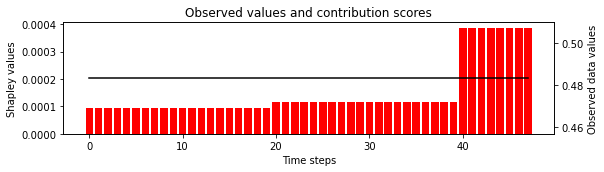

In [ ]:
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_1[phi_index, :, var], var_name='Observed', plot_type='bar')

## Heatmap for Sliding SHAP

[-0.00817528 -0.00317528  0.          0.00182472  0.00682472  0.01182472]


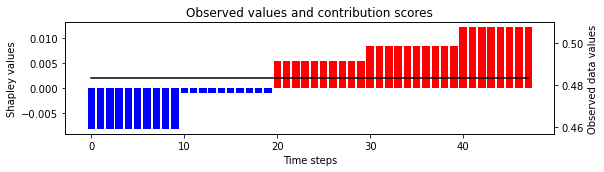

In [ ]:
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_2[phi_index, :, var], var_name='Observed', plot_type='bar')

## Heatmap for Dynamic SHAP

[0.00000000e+00 6.77440852e-05]


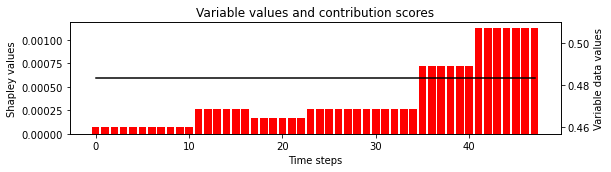

In [ ]:
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_3[phi_index, :, var], var_name='Variable', plot_type='bar')

In [ ]:
###### Single prediction model

# 1- transformer - produces attention for same time steps and then run windoeSHAP on transformers and get shap based attention, compare both.
# 2- RETAIN - produces attention for same time steps and then run windowSHAP on retain and shap based explanations, compare both. 

In [ ]:
# import math
# from copy import deepcopy

# def xai_eval_fnc(model, relevence, input_x, model_type='lstm', percentile=90,
#                  eval_type='prtb', seq_len=10, by='all'):
#     """
#     Evaluates the quality metrics of time-series importance scores using various evaluation methods.

#     Parameters
#     ----------
#     model : prediction model that is explained 
#     relevance : A 3D array of importance scores for each time step of the time-series data
#     input_x : input data of the prediction model. If the input data consists of different modalities, the first module should be a 3D time series data
#     model_type (optional) : type of model, either 'lstm' or 'lstm_plus'. Use 'lstm' when the time series data is the only modality of the input, otherwise use 'lstm_plus'
#     percentile (optional) : percentile of top time steps that are going to be pertubed
#     eval_type (optional) : evaluation method, either 'prtb' for the perturbation analysis metric or 'sqnc' for sequence analysis metric
#     seq_len (optional) : sequence length for 'sqnc' method
#     by (optional) : whether to evaluate each temporal feature separately or all time steps together, either 'time' or 'all'

#     Returns : prediction of the modified input time-series data using the input model
#     """
    
#     input_new = deepcopy(input_x)
#     relevence = np.absolute(relevence)
    
#     # TO DO: Add other type of models
#     if model_type == 'lstm_plus':
#         input_ts = input_x[0]
#         input_new_ts = input_new[0]
#     elif model_type == 'lstm':
#         input_ts = input_x
#         input_new_ts = input_new
    
#     assert len(input_ts.shape)==3 # the time sereis data needs to be 3-dimensional
#     num_feature = input_ts.shape[2]
#     num_time_step = input_ts.shape[1]
#     num_instance = input_ts.shape[0]
        
#     if by=='time':
#         top_steps = math.ceil((1 - percentile/100) * num_time_step) # finding the number of top steps for each feature
#         top_indices = np.argsort(relevence, axis=1)[:, -top_steps:, :] # a 3d array of top time steps for each feature
#         for j in range(num_feature): # converting the indices to a flatten version
#             top_indices[:, :, j] = top_indices[:, :, j] * num_feature + j
#         top_indices = top_indices.flatten()
#     elif by=='all':
#         top_steps = math.ceil((1 - percentile/100) * num_time_step * num_feature) # finding the number of all top steps
#         top_indices = np.argsort(relevence, axis=None)[-top_steps:]
    
#     # Create a masking matrix for top time steps
#     top_indices_mask = np.zeros(input_ts.size)
#     top_indices_mask[top_indices] = 1
#     top_indices_mask = top_indices_mask.reshape(input_ts.shape)
    
    
#     # Evaluating different metrics
#     for p in range(num_instance):
#         for v in range(num_feature):
#             for t in range(num_time_step):
#                 if top_indices_mask[p, t, v]:
#                     if eval_type == 'prtb':
#                         input_new_ts[p,t,v] = np.max(input_ts[p,:,v]) - input_ts[p,t,v]
#                     elif eval_type == 'sqnc':
#                         input_new_ts[p, t:t + seq_len, v] = 0
    
#     return model.predict(input_new)

In [ ]:
### load keras model
from tensorflow import keras

model = keras.models.load_model('mimic3_ts_transformer.h5', compile=False)

2023-03-02 23:44:00.180174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-02 23:44:00.207112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-02 23:44:00.207273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-02 23:44:00.207836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
model, ts_phi_1.shape, test_x.shape

(<keras.engine.functional.Functional at 0x7f064ab419d0>,
 (17, 48, 26),
 (4598, 48, 26))

In [ ]:
# from util import xai_eval

In [ ]:
#xai_eval_fnc(model, relevence, input_x)
xai_res_prtb_tsphi1 = xai_eval_fnc(model, ts_phi_1, test_x, eval_type='prtb')

xai_res_prtb_tsphi2 = xai_eval_fnc(model, ts_phi_2, test_x, eval_type='prtb')

xai_res_prtb_tsphi3 = xai_eval_fnc(model, ts_phi_3, test_x, eval_type='prtb')

144/144 [==============================] - 13s 90ms/step


In [ ]:
seq_len_val  = 48


xai_res_sqnc_tsphi1 = xai_eval_fnc(model, ts_phi_1, test_x, eval_type='sqnc',seq_len=seq_len_val)

xai_res_sqnc_tsphi2 = xai_eval_fnc(model, ts_phi_2, test_x, eval_type='sqnc',seq_len=seq_len_val)

xai_res_sqnc_tsphi3 = xai_eval_fnc(model, ts_phi_3, test_x, eval_type='sqnc',seq_len=seq_len_val)

144/144 [==============================] - 26s 182ms/step


In [ ]:
xai_res_prtb_tsphi1.shape,xai_res_prtb_tsphi1.shape, xai_res_prtb_tsphi1.shape 

((4598, 1), (4598, 1), (4598, 1))

In [ ]:
xai_res_sqnc_tsphi1.shape, xai_res_sqnc_tsphi2.shape, xai_res_sqnc_tsphi3.shape

((4598, 1), (4598, 1), (4598, 1))

In [ ]:
# xai_res_prtb ## check if we need to flatten it??? =no

In [ ]:
# np.save('xai_res_prtb_wshap_tsphi1.npy',xai_res_prtb)

In [ ]:
# np.save('xai_res_sqnc_wshap_tsphi1.npy',xai_res_sqnc)

In [ ]:
#################### analysis of new prediction
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, average_precision_score, matthews_corrcoef

In [ ]:
######### model prediction
y_pred_orig = model.predict(test_x)

144/144 [==============================] - 15s 103ms/step


In [ ]:
################# original model prediction

print('original_model_predictions: ',roc_auc_score(test_y, y_pred_orig), average_precision_score(test_y, y_pred_orig),f1_score(test_y, np.round(y_pred_orig)),
      recall_score(test_y, np.round(y_pred_orig)),precision_score(test_y, np.round(y_pred_orig)),matthews_corrcoef(test_y, np.round(y_pred_orig)))

original_model_predictions:  0.7603732886104254 0.28575738206576495 0.22591362126245845 0.14847161572052403 0.4722222222222222 0.2237180431912803


In [ ]:
print('prtb_analysis_wshap_tsphi1: ',roc_auc_score(test_y, xai_res_prtb_tsphi1), average_precision_score(test_y, xai_res_prtb_tsphi1),f1_score(test_y, np.round(xai_res_prtb_tsphi1)),
      recall_score(test_y, np.round(xai_res_prtb_tsphi1)),precision_score(test_y, np.round(xai_res_prtb_tsphi1)),matthews_corrcoef(test_y, np.round(xai_res_prtb_tsphi1)))

print('prtb_analysis_wshap_tsphi2: ',roc_auc_score(test_y, xai_res_prtb_tsphi2), average_precision_score(test_y, xai_res_prtb_tsphi2),f1_score(test_y, np.round(xai_res_prtb_tsphi2)),
      recall_score(test_y, np.round(xai_res_prtb_tsphi2)),precision_score(test_y, np.round(xai_res_prtb_tsphi2)),matthews_corrcoef(test_y, np.round(xai_res_prtb_tsphi2)))

print('prtb_analysis_wshap_tsphi3: ',roc_auc_score(test_y, xai_res_prtb_tsphi3), average_precision_score(test_y, xai_res_prtb_tsphi3),f1_score(test_y, np.round(xai_res_prtb_tsphi3)),
      recall_score(test_y, np.round(xai_res_prtb_tsphi3)),precision_score(test_y, np.round(xai_res_prtb_tsphi3)),matthews_corrcoef(test_y, np.round(xai_res_prtb_tsphi3)))

prtb_analysis_wshap_tsphi1:  0.7606164166824885 0.28608803361012997 0.22591362126245845 0.14847161572052403 0.4722222222222222 0.2237180431912803
prtb_analysis_wshap_tsphi2:  0.7605098833407168 0.2859545580939678 0.22591362126245845 0.14847161572052403 0.4722222222222222 0.2237180431912803
prtb_analysis_wshap_tsphi3:  0.7604402674936186 0.2858610487953817 0.22591362126245845 0.14847161572052403 0.4722222222222222 0.2237180431912803


In [ ]:
print('sqnc_analysis_wshap_tsphi1: ',roc_auc_score(test_y, xai_res_sqnc_tsphi1), average_precision_score(test_y, xai_res_sqnc_tsphi1),f1_score(test_y, np.round(xai_res_sqnc_tsphi1)),
      recall_score(test_y, np.round(xai_res_sqnc_tsphi1)),precision_score(test_y, np.round(xai_res_sqnc_tsphi1)),matthews_corrcoef(test_y, np.round(xai_res_sqnc_tsphi1)))


print('sqnc_analysis_wshap_tsphi2: ',roc_auc_score(test_y, xai_res_sqnc_tsphi2), average_precision_score(test_y, xai_res_sqnc_tsphi2),f1_score(test_y, np.round(xai_res_sqnc_tsphi2)),
      recall_score(test_y, np.round(xai_res_sqnc_tsphi2)),precision_score(test_y, np.round(xai_res_sqnc_tsphi2)),matthews_corrcoef(test_y, np.round(xai_res_sqnc_tsphi2)))

print('sqnc_analysis_wshap_tsphi3: ',roc_auc_score(test_y, xai_res_sqnc_tsphi3), average_precision_score(test_y, xai_res_sqnc_tsphi3),f1_score(test_y, np.round(xai_res_sqnc_tsphi3)),
      recall_score(test_y, np.round(xai_res_sqnc_tsphi3)),precision_score(test_y, np.round(xai_res_sqnc_tsphi3)),matthews_corrcoef(test_y, np.round(xai_res_sqnc_tsphi3)))

sqnc_analysis_wshap_tsphi1:  0.76056684176107 0.28608899492999135 0.22591362126245845 0.14847161572052403 0.4722222222222222 0.2237180431912803
sqnc_analysis_wshap_tsphi2:  0.7604186443895955 0.2858995540180984 0.22591362126245845 0.14847161572052403 0.4722222222222222 0.2237180431912803
sqnc_analysis_wshap_tsphi3:  0.7602282555956373 0.285652797637522 0.22591362126245845 0.14847161572052403 0.4722222222222222 0.2237180431912803


In [ ]:
########################### 